In [1]:
import keras
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
#import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
#from at_nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/data/raihan/thesis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/local/data/raihan/thesis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/data/raihan/thesis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/data/raihan/thesis/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
#%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys 
import os
sys.path.insert(0,'..')
from utils import plot_stroke

In [5]:
strokes = np.load('strokes.npy',encoding='bytes')

In [6]:
Ty = 400
Tx = 400
m = len(strokes)

In [7]:
def pad_stroke(stroke,Ty):
    _npads = Ty - stroke.shape[0] 
    padded_stroke = np.vstack ([ stroke,np.zeros((_npads,3)) ])
    #padded_strokes.shape
    return padded_stroke

def tranc_stroke(stroke, Ty):
    if stroke.shape[0] >= Ty:
        stroke = stroke[:Ty,]
    elif stroke.shape[0] < Ty:
        stroke = pad_stroke(stroke,Ty)
    return stroke

new_strokes = np.array(list(map(lambda x: tranc_stroke(x, Ty+1), strokes)))


In [8]:
input_strokes = new_strokes[:,:Ty,:]
output_strokes = new_strokes[:,1:Ty+1,:]

In [18]:
Xoh = input_strokes
Yoh = output_strokes

In [ ]:
Xoh.shape

In [ ]:
Yoh.shape

In [10]:
def softmax(x, axis=1):
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s

In [11]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [12]:
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
   
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a"
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis 
    concat = concatenator ([s_prev,a])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. 
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. 
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" 
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell 
    context = dotor([alphas,a])

    
    return context

In [13]:
n_a = 50
n_s = 100

post_activation_LSTM_cell = LSTM(n_s, return_state = True)
#output_layer = Dense(len(machine_vocab), activation=softmax)
output_layer = Dense(3)

In [14]:
# GRADED FUNCTION: model

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):

    
    # Define the inputs of model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    

    
    #  Define pre-attention Bi-LSTM. Remember to use return_sequences=True. 
    a = Bidirectional(LSTM(n_a, return_sequences=True),input_shape=(Tx, human_vocab_size))(X)
    
    for t in range(Ty):
    
        # Compute one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention(a, s)
        
        # Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = post_activation_LSTM_cell(context,initial_state= [s, c])
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        
        #  Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Create model instance taking three inputs and returning the list of outputs.
    
    model = Model(inputs=[X,s0,c0], outputs=outputs)

    
    return model

In [15]:
model = model(Tx, Ty, n_a, n_s, 3, 3)

In [ ]:
#model.summary()

In [16]:
opt = Adam(lr=0.005, decay=0.01, beta_1=0.9, beta_2=0.999)
#model.compile(optimizer=opt,
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])opt = Adam(lr=0.005, decay=0.01, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['accuracy'])


In [19]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [ ]:
filepath="weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
model.fit([Xoh, s0, c0], outputs, monitor='val_loss', epochs = 100, batch_size = 100,callbacks=callbacks_list)

In [20]:
model.load_weights("Attention-LSTM-100.Maxlen-400.weights.01-1119.31.hdf5")

In [21]:
source = np.zeros((1,400,3))

In [22]:
result = []
for i in range(100):    
    prediction = model.predict([source, s0, c0])
    source = np.array(prediction).swapaxes(0,1)
    result.append(source)
#np.savetxt("gen_strokes.csv", result, delimiter=",")

In [26]:
result[-1]

(1, 400, 3)

In [ ]:
predicted_strokes = np.array(prediction).swapaxes(0,1)

In [ ]:
predicted_strokes

In [51]:
result[-1][0][1:2,0] = 1

In [41]:
result[-1][0]

array([[ 1.       , -1.0566717, -0.3155106],
       [ 1.       , -1.8772689, -0.7545672],
       [ 1.       , -2.5052214, -1.2756416],
       ...,
       [ 1.       , -3.7145483, -1.4117122],
       [ 1.       , -3.7199283, -1.4379841],
       [ 1.       , -3.7244256, -1.4662347]], dtype=float32)

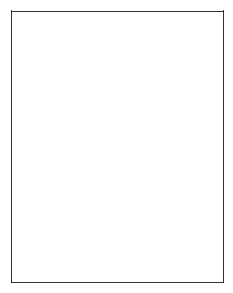

In [52]:
plot_stroke(result[-1])

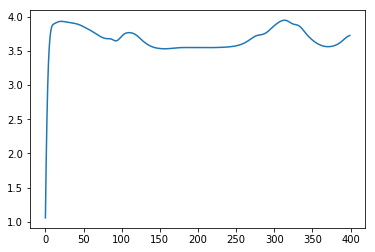

In [61]:
plt.plot(-1 *result[-1][0][:,1])